In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision

import PIL

import numpy as np
import matplotlib.pyplot as plt

import os
import re

In [2]:
from tqdm.auto import tqdm

In [3]:
import pandas as pd

In [4]:
f_path = "data/fold/"

In [5]:
al = pd.read_csv(f_path +  'folder_label.csv')

In [6]:
al.head()

,Unnamed: 0,I,II,III,IV
0,dress-01,"0,1,-28","0,1,-56","1,0,-35","1,0,-56"
1,dress2-01,"0, 1, -42","0, 1, -28","1, 0, -42",NaN
2,dress3-01,"1, 0, -21","0, 1, -42","1, 0, -49","0, 1, -28"
3,pants-01,"1, 0, -42","0, 1, -42",NaN,NaN
4,pants2-01,"0, 1, -28","0, 1, -56","0, 1, -42","1, 0, -42"


In [7]:
os.listdir(f_path)

['dress-01',
 'dress2-01',
 'dress3-01',
 'folder_label.csv',
 'pants-01',
 'pants2-01',
 'pants3-01',
 'shirt-01',
 'shirt2-01',
 'shirt3-01',
 'shortpants-01',
 'shortpants2-01',
 'shortpants3-01',
 'skirt-01',
 'skirt2-01',
 'skirt3-01',
 'Tshirt-01',
 'Tshirt2-01',
 'Tshirt3-01',
 'vest-01',
 'vest2-01',
 'vest3-01']

In [8]:
IMAGE_SIZE = 28

In [9]:
# image_list = []

In [10]:
# for dress_folder in os.listdir(folder_path):
#         if dress_folder.endswith(".csv"):
#             action_list = pd.read_csv(folder_path + dress_folder)
#         else:
#             dress_image_list = []
#             image_folder = os.path.join(folder_path, dress_folder)
#             for file_name in os.listdir(image_folder):
#                 #image_list.append(os.path.join(image_folder, file_name))
#                 single_image_path = os.path.join(image_folder, file_name)
#                 dress_image_list.append(single_image_path)
            
#             image_list.append(dress_image_list)

In [11]:
class ClothImages(Dataset):
    def __init__(self, folder_path,  transforms=None, revert=False):
        self.revert = revert
        self.data_root_folder = folder_path
        self.image_list, self.action_list  = self.load_image_list(self.data_root_folder)
        self.transforms = transforms
        
    def load_image_list(self, folder_path):
        image_list = []
        action_list = None
        for dress_folder in os.listdir(folder_path):
            if dress_folder.endswith(".csv"):
                action_list = pd.read_csv(folder_path + dress_folder)
            else:
                dress_image_list = []
                image_folder = os.path.join(folder_path, dress_folder)
                order_image_list = os.listdir(image_folder)
                if self.revert:
                    order_image_list = order_image_list[::-1]
                for file_name in order_image_list:
                    #image_list.append(os.path.join(image_folder, file_name))
                    single_image_path = os.path.join(image_folder, file_name)
                    dress_image_list.append(single_image_path)

                image_list.append(dress_image_list)
        
        return image_list, action_list
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        img_list = [] 
        for dress_image_path in self.image_list[index]:
            #print(dress_image_path)
            # Open image
            img = PIL.Image.open(dress_image_path).convert("L")
            img = PIL.ImageOps.invert(img)
            #img = resize(img,(IMAGE_SIZE,IMAGE_SIZE))
            if self.transforms is not None:
                img = self.transforms(img)
            
            img_list.append(img)
        
        img_tensor = torch.stack(img_list,dim=0)
        return img_tensor
        

In [12]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((IMAGE_SIZE,IMAGE_SIZE), interpolation= PIL.Image.NEAREST),
    torchvision.transforms.RandomAffine(degrees = 90, translate = (0.2,0.2), scale = (0.6,1)),
    #torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    # torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR)
    torchvision.transforms.ToTensor(),
])

In [13]:
ci = ClothImages(f_path, transforms, revert=True)

In [14]:
ci[0].shape

torch.Size([5, 1, 28, 28])

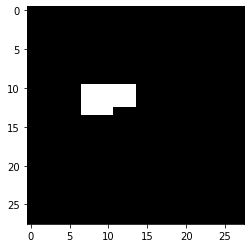

In [18]:
plt.imshow(ci[3][0][0].data.numpy(),cmap="gray")

In [19]:
def conv3x3(in_channels, out_channels, **kwargs):
    # The convolutional layers (for feature extraction) use standard layers from
    # `torch.nn`, since they do not require adaptation.
    # See `examples/maml/model.py` for comparison.
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, **kwargs),
        nn.BatchNorm2d(out_channels, momentum=1., track_running_stats=False),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

In [20]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, in_channels, out_features, hidden_size=64):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.in_channels = in_channels
        self.out_features = out_features
        self.hidden_size = hidden_size

        self.features = nn.Sequential(
            conv3x3(in_channels, hidden_size),
            conv3x3(hidden_size, hidden_size),
            conv3x3(hidden_size, hidden_size),
            conv3x3(hidden_size, hidden_size)
        )

        # Only the last (linear) layer is used for adaptation in ANIL
        self.linear_aesthetics = nn.Sequential(
            nn.Linear(hidden_size, out_features),
            nn.Sigmoid(),
        )

    def forward(self, inputs, params=None):
        features = self.features(inputs)
        #print(features.shape)
        features = features.view((features.size(0), -1))
        #print(features.shape)
        scores = self.linear_aesthetics(features)
        return scores

In [21]:
def complete_contrast_loss(score_tensor):
    total_loss = 0.0
    for i in range(len(score_tensor)):
        if i == 0:
            total_loss += (1.0 - score_tensor[i])**2
            total_loss += (score_tensor[i] - score_tensor[i + 1])**2
        elif i ==len(score_tensor) - 1:
            total_loss += (score_tensor[i] - 0.0)**2
        else:
            total_loss += (score_tensor[i] - score_tensor[i + 1])**2
    
    return total_loss

In [22]:
model = ConvolutionalNeuralNetwork(1, 1, hidden_size=64)

In [23]:
# pretrained_dict = torch.load("10_29.pth")
# model_dict = model.state_dict()
# # 1. filter out unnecessary keys
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# # 2. overwrite entries in the existing state dict
# model_dict.update(pretrained_dict) 
# # 3. load the new state dict
# model.load_state_dict(model_dict)

In [24]:
if torch.cuda.is_available():
    model = model.cuda()

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [26]:
epochs = 100

In [27]:
len(ci)

21

In [28]:
with tqdm(range(epochs)) as pbar:
    loss_list = []
    for epoch in pbar:
        loss_epoch = []
        count = 0
        random_sequences = np.arange(18)
        np.random.shuffle(random_sequences)
        for i in random_sequences:
            batch_inputs = ci[i]

            if torch.cuda.is_available():
                batch_inputs = batch_inputs.to("cuda")

            pred_scores = model(batch_inputs)

            loss = complete_contrast_loss(pred_scores)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_epoch.append(loss.item())

        #print("epoch: {} avg loss {:.2f}".format(epoch, sum(loss_epoch)/(len(loss_epoch) + 1e-3)))
        avg_loss = sum(loss_epoch)/(len(loss_epoch) + 1e-3)
        loss_list.append(avg_loss)
        pbar.set_postfix(accuracy='{0:.4f}'.format(avg_loss))

In [31]:
torch.save(model, "record/vl3.pth")

In [29]:
model(ci[20].cuda())

tensor([[0.6435],
        [0.6016],
        [0.5018],
        [0.1870]], device='cuda:0', grad_fn=<SigmoidBackward>)

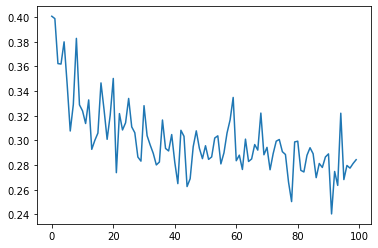

In [30]:
plt.plot(loss_list)

In [32]:
print(*loss_list)

0.40075963029966877 0.3988362157962685 0.36233319692377 0.36198861015802564 0.3799869298179986 0.345465042718112 0.3076699819970638 0.3291350355758103 0.38281248666254597 0.32889799941652953 0.32401001375255684 0.31374667983645566 0.33288271776418354 0.29279312324698753 0.3000715602921695 0.3060002026243492 0.34667275281861304 0.32492405732110713 0.3009246557025497 0.32059026224057835 0.3502915578844494 0.27386907153471024 0.32179031025852783 0.308511535443635 0.31432811981849845 0.33407848193628126 0.31100691248924095 0.30626073329821274 0.28655165669308935 0.283226874939409 0.32820992271513827 0.3038766940271422 0.29634588837961334 0.2895639329266266 0.28014032219947754 0.2825220030788898 0.316587381214309 0.2935302965469237 0.29149043676581793 0.30477853339484356 0.2823697829284931 0.2649789134381009 0.3082324513713026 0.3033539356970004 0.2626015437218184 0.268926960409671 0.2949588304161727 0.3077907616161954 0.2937154207724438 0.2852501970060361 0.29571081216411715 0.284650049655

In [33]:
model2 = ConvolutionalNeuralNetwork(1, 1, hidden_size=64)

In [34]:
pretrained_dict = torch.load("10_26.pth")
model2_dict = model2.state_dict()
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model2_dict}
# 2. overwrite entries in the existing state dict
model2_dict.update(pretrained_dict) 
# 3. load the new state dict
model2.load_state_dict(model2_dict)

if torch.cuda.is_available():
    model2 = model2.cuda()

optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-5)


In [35]:
epochs = 100

In [36]:
with tqdm(range(epochs)) as pbar:
    loss_list = []
    for epoch in pbar:
        loss_epoch = []
        count = 0
        random_sequences = np.arange(18)
        np.random.shuffle(random_sequences)
        for i in random_sequences:
            batch_inputs = ci[i]

            if torch.cuda.is_available():
                batch_inputs = batch_inputs.to("cuda")

            pred_scores = model2(batch_inputs)

            loss = complete_contrast_loss(pred_scores)

            optimizer2.zero_grad()
            loss.backward()
            optimizer2.step()

            loss_epoch.append(loss.item())

        #print("epoch: {} avg loss {:.2f}".format(epoch, sum(loss_epoch)/(len(loss_epoch) + 1e-3)))
        avg_loss = sum(loss_epoch)/(len(loss_epoch) + 1e-3)
        loss_list.append(avg_loss)
        pbar.set_postfix(accuracy='{0:.4f}'.format(avg_loss))

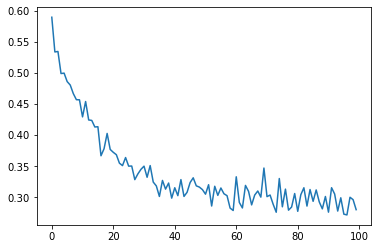

In [37]:
plt.plot(loss_list)

In [38]:
print(*loss_list)

0.5894183605937492 0.5335811939274467 0.5343314704150135 0.4988291513111239 0.4994984742873417 0.4859108751624513 0.4803106328671683 0.46652342390930657 0.4567267791965684 0.45658511179340233 0.42910269846963084 0.45378353289647677 0.42413561438581726 0.42341137374747384 0.41284058221306613 0.41324154852920153 0.3665479846970451 0.37783917423937224 0.40243652375378436 0.3767037870459977 0.37207696532005796 0.3682305369666666 0.3545961094050929 0.3506766992187203 0.363657728949293 0.3498366018658406 0.34997575773503287 0.32812177648173985 0.33730141163322636 0.34467960309931966 0.3497975530587834 0.33191708675802206 0.35072380082818255 0.32418069458823684 0.31800540538173494 0.30104758759206096 0.32682225301023204 0.3128316197340491 0.3226377874154209 0.2983509244259765 0.31507347671265507 0.3023288225599159 0.3281466616941064 0.30109221326279034 0.3077284136544823 0.3234762399370528 0.3310302884490892 0.31813381066038093 0.3161233235753832 0.3120418374958677 0.30472890452327783 0.31991

In [39]:
model(ci[1].cuda())

tensor([[0.6165],
        [0.6018],
        [0.3355],
        [0.3033]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [40]:
model2(ci[2].cuda())

tensor([[0.7214],
        [0.5717],
        [0.4230],
        [0.2896],
        [0.3353]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [41]:
torch.save(model2, "record/vl3_pre.pth")

# Test

In [ ]:
import copy
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [ ]:
import json

In [ ]:
from fold_actions import point_line_symmetry, matrix_line_symmetry

In [ ]:
def read_cloth_image(cloth_file):
    im = Image.open(cloth_file).convert("L")
    display(im)
    im_np = np.asarray(im)
    im_np = 1 - im_np / 255.0
    
    for i in range(len(im_np)):
        for j in range(len(im_np[0])):
            if im_np[i][j] > 0:
                im_np[i][j] = 1
    
    return im_np

In [ ]:
transforms_after = torchvision.transforms.Compose([
    torchvision.transforms.Resize((IMAGE_SIZE,IMAGE_SIZE),interpolation = PIL.Image.NEAREST),
    #torchvision.transforms.RandomAffine(degrees = 90, translate = (0.2,0.2), scale = (0.6,1)),
    #torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    #torchvision.transforms.RandomHorizontalFlip(),
    #torchvision.transforms.RandomVerticalFlip(),
    # torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR)
    torchvision.transforms.ToTensor(),
])


In [ ]:
model = model.cpu()

model2 = model2.cpu()

In [ ]:
cloth_folder = "C:\\Users\\Yizhou Zhao\\Desktop\\AI\\validation\\"

In [ ]:
os.listdir(cloth_folder)

In [ ]:
torch.save(model,"record/vl2.pth")
torch.save(model2,"record/vl2_pre.pth")

In [ ]:
for file_name in os.listdir(cloth_folder):
    if file_name.endswith(".png"):
        print("-----------\n",file_name)
        cloth_name = file_name

        cloth_file = cloth_folder + cloth_name

        cloth_img = read_cloth_image(cloth_file)

        #plt.imshow(cloth_img, cmap="gray")

        img = Image.fromarray(np.uint8(cloth_img * 255) , 'L')

        t3 = transforms_after(img)

        print(t3.shape)

        plt.imshow(t3[0].data.numpy(), cmap="gray")

        print(model(t3.unsqueeze(0)).item(), model2(t3.unsqueeze(0)).item())

In [ ]:
plt.imshow(ci[6][0][0].data.numpy(), cmap="gray")

In [ ]:
model2(ci[6])

In [ ]:
# cloth_name = "rectangle_small-01-01.png"

# cloth_file = cloth_folder + cloth_name

# cloth_img = read_cloth_image(cloth_file)

# #plt.imshow(cloth_img, cmap="gray")

# img = Image.fromarray(np.uint8(cloth_img * 255) , 'L')

# t3 = transforms_after(img)

# print(t3.shape)

# plt.imshow(t3[0].data.numpy(), cmap="gray")

In [ ]:
cloth_file = "C:\\Users\\Yizhou Zhao\\Desktop\\AI\\validation\\" + "dress4-01.png"

In [ ]:
#cloth_file =  "data/clothes/" + "shirt3-01.png"

In [ ]:
control_cloth_img = read_cloth_image(cloth_file)

In [ ]:
def fold_action(cloth, value_model, method = "greedy"):
    img = Image.fromarray(np.uint8(cloth * 255) , 'L')
    img_t = transforms_after(img)
    img_t_score = value_model(img_t.unsqueeze(0)).item()
    
    action = (1, 0, 0)
    folded_cloth_save_image = None
    min_score = 1.0
    for i in range(1, 11):
        c = - i * 7
        for a, b in [(1, 0), (0, 1)]:
            cloth_folded = matrix_line_symmetry(cloth, a, b, c)
            img_folded = Image.fromarray(np.uint8(cloth_folded * 255) , 'L')
            img_folded_t = transforms_after(img_folded)
            img_folded_t_score = value_model(img_folded_t.unsqueeze(0)).item()
            
            if min_score > img_folded_t_score:
                print(action, min_score)
                min_score = img_folded_t_score
                action = (a, b, c)
                folded_cloth_save_image = cloth_folded
    
    return action, min_score, folded_cloth_save_image

In [ ]:
curA, curS, curImge = fold_action(control_cloth_img, model2)

In [ ]:
curA

In [ ]:
curS

In [ ]:
plt.imshow(1-curImge, cmap="gray")

In [ ]:
control_cloth_img = curImge